Entropy (Random Series): 2.9531158726663764
Entropy (Less Random Series): 2.8363230094276357

Ljung-Box p-value (Random Series): 2     0.738402
5     0.688834
10    0.940607
Name: lb_pvalue, dtype: float64
Ljung-Box p-value (Less Random Series): 2      8.350556e-84
5     1.498344e-191
10     0.000000e+00
Name: lb_pvalue, dtype: float64

Kolmogorov-Smirnov Test p-value: 6.753917316595921e-20


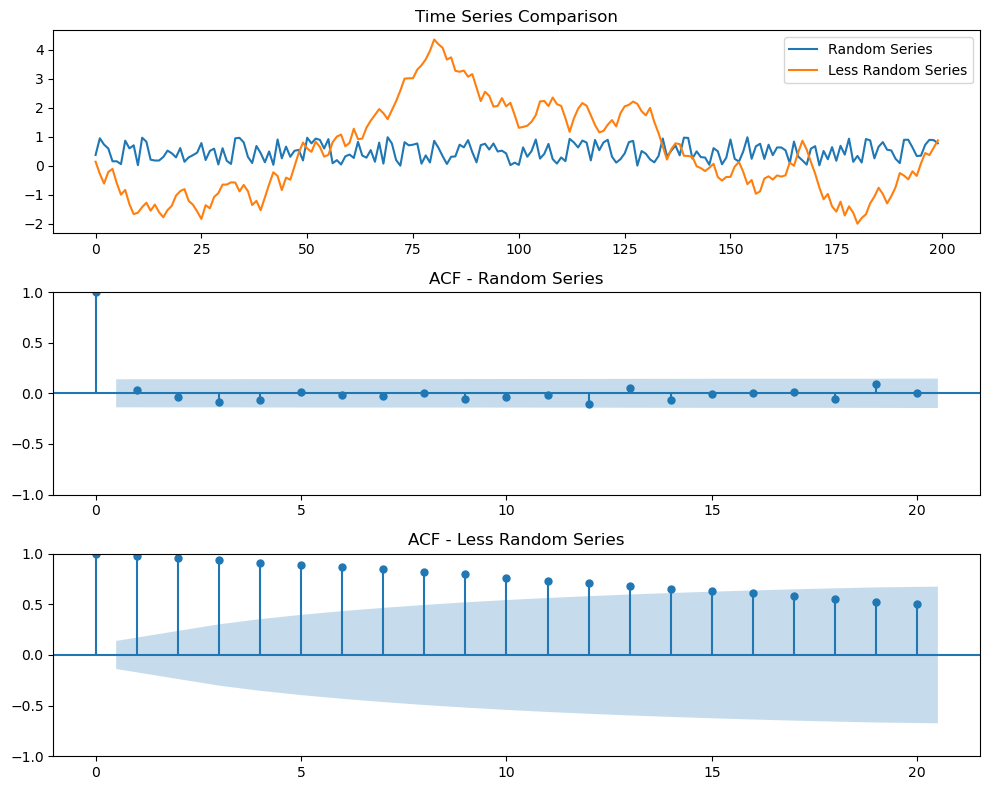

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import entropy, ks_2samp

np.random.seed(42)
series_random = np.random.rand(200)  # Pure random series
series_less_random = np.cumsum(np.random.rand(200) - 0.5)  # Random walk (has structure)

def approximate_entropy(series, bins=20):
    hist, _ = np.histogram(series, bins=bins, density=True)
    return entropy(hist)

entropy_random = approximate_entropy(series_random)
entropy_less_random = approximate_entropy(series_less_random)

ljungbox_random = acorr_ljungbox(series_random, lags=[2,5,10], return_df=True)
ljungbox_less_random = acorr_ljungbox(series_less_random, lags=[2,5,10], return_df=True)

ks_test = ks_2samp(series_random, series_less_random)

print("Entropy (Random Series):", entropy_random)
print("Entropy (Less Random Series):", entropy_less_random)
print("\nLjung-Box p-value (Random Series):", ljungbox_random['lb_pvalue'])
print("Ljung-Box p-value (Less Random Series):", ljungbox_less_random['lb_pvalue'])
print("\nKolmogorov-Smirnov Test p-value:", ks_test.pvalue)

fig, axs = plt.subplots(3, 1, figsize=(10, 8))

axs[0].plot(series_random, label="Random Series")
axs[0].plot(series_less_random, label="Less Random Series")
axs[0].set_title("Time Series Comparison")
axs[0].legend()

plot_acf(series_random, ax=axs[1], lags=20, title="ACF - Random Series")
plot_acf(series_less_random, ax=axs[2], lags=20, title="ACF - Less Random Series")

plt.tight_layout()
plt.show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


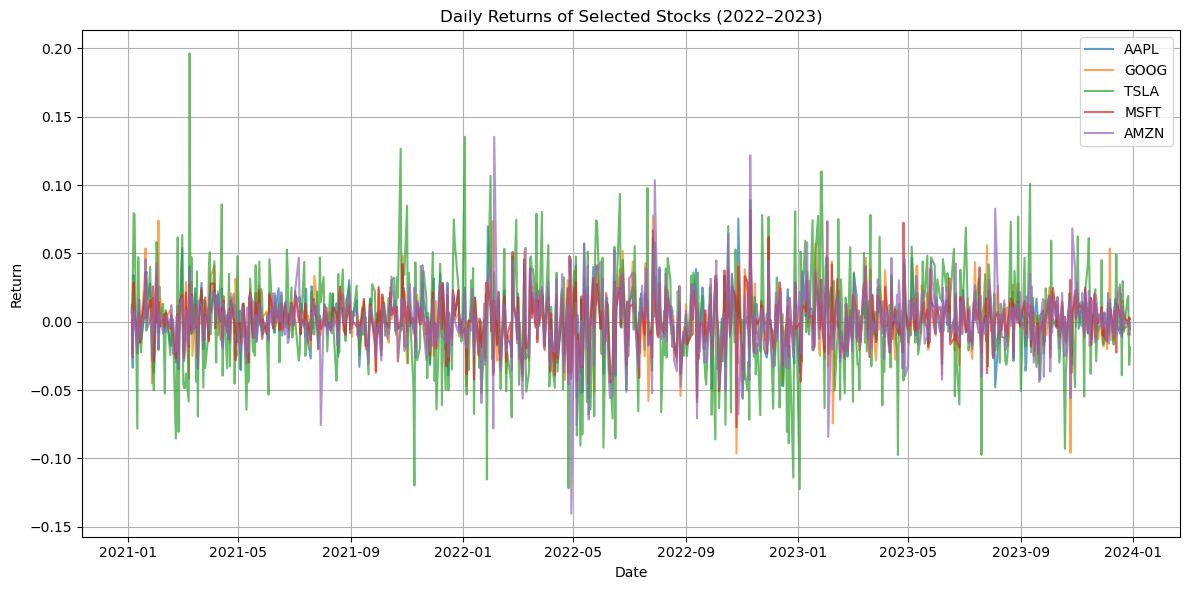

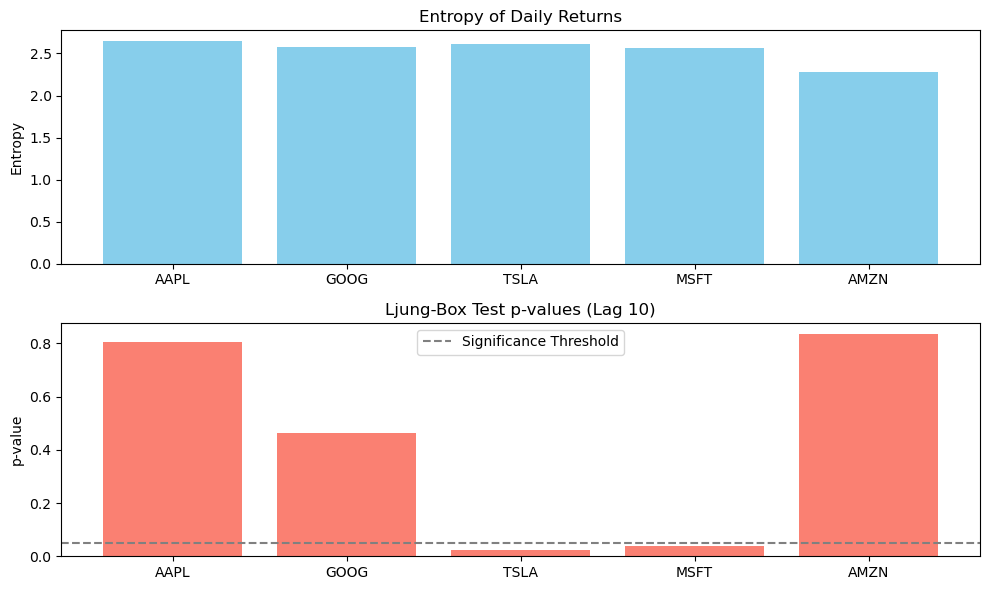

  Ticker   Entropy  Ljung-Box p-value
0   AAPL  2.642995           0.805758
1   GOOG  2.581001           0.462543
2   TSLA  2.608850           0.022895
3   MSFT  2.561511           0.036769
4   AMZN  2.279393           0.835152


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import entropy

tickers = ['AAPL', 'GOOG', 'TSLA', 'MSFT', 'AMZN']
data = yf.download(tickers, start='2021-01-01', end='2023-12-31')['Close']

# Compute daily returns
returns = data.pct_change().dropna()

def approximate_entropy(series, bins=30):
    hist, _ = np.histogram(series, bins=bins, density=True)
    return entropy(hist)

results = []
for ticker in tickers:
    series = returns[ticker].dropna()
    ent = approximate_entropy(series)
    ljungbox_p = acorr_ljungbox(series, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    results.append({'Ticker': ticker, 'Entropy': ent, 'Ljung-Box p-value': ljungbox_p})

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(returns[ticker], label=ticker, alpha=0.7)
plt.title("Daily Returns of Selected Stocks (2022–2023)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Bar plot for Entropy
ax[0].bar(results_df['Ticker'], results_df['Entropy'], color='skyblue')
ax[0].set_title("Entropy of Daily Returns")
ax[0].set_ylabel("Entropy")

# Bar plot for Ljung-Box p-values
ax[1].bar(results_df['Ticker'], results_df['Ljung-Box p-value'], color='salmon')
ax[1].set_title("Ljung-Box Test p-values (Lag 10)")
ax[1].set_ylabel("p-value")
ax[1].axhline(0.05, color='gray', linestyle='--', label='Significance Threshold')
ax[1].legend()

plt.tight_layout()
plt.show()

print(results_df)

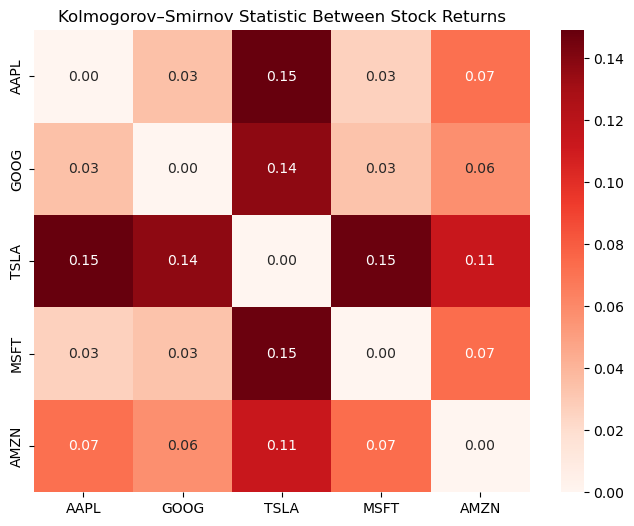

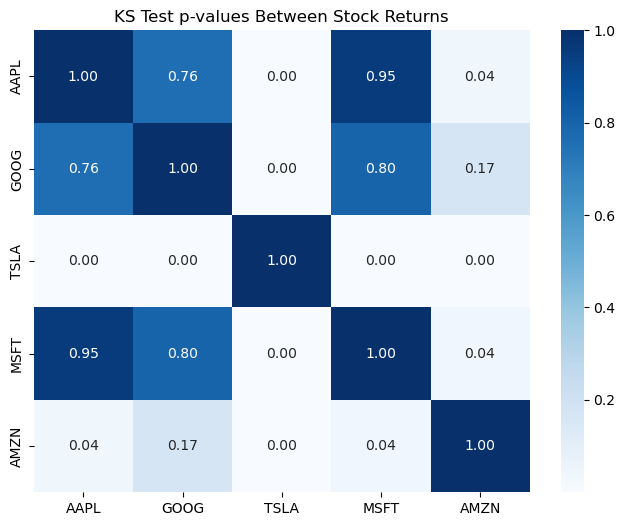

In [5]:
import itertools
from scipy.stats import ks_2samp
import seaborn as sns

# Create empty matrices for KS statistic and p-value
ks_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)
pval_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

# Fill matrices
for t1, t2 in itertools.product(tickers, repeat=2):
    if t1 == t2:
        ks_matrix.loc[t1, t2] = 0.0
        pval_matrix.loc[t1, t2] = 1.0
    else:
        ks_stat, pval = ks_2samp(returns[t1], returns[t2])
        ks_matrix.loc[t1, t2] = ks_stat
        pval_matrix.loc[t1, t2] = pval

# Plot KS statistic heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(ks_matrix.astype(float), annot=True, cmap='Reds', fmt=".2f")
plt.title("Kolmogorov–Smirnov Statistic Between Stock Returns")
plt.show()

# Plot p-value heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pval_matrix.astype(float), annot=True, cmap='Blues', fmt=".2f")
plt.title("KS Test p-values Between Stock Returns")
plt.show()


### Spectral Entropy

**Spectral entropy** is a measure of the **uncertainty** or **complexity** of a signal in the frequency domain. It is computed as the **Shannon entropy** of the **normalized power spectral density (PSD)**.

Let $x(t)$ be a time series. Compute its power spectral density $P(f)$ , and normalize it to form a probability distribution:


$p_i = \frac{P(f_i)}{\sum_j P(f_j)}$


The **spectral entropy** is then defined as:


$H = -\sum_{i} p_i \log(p_i)$


To make it scale-invariant, it can be normalized by $\log(N)$, where $N$ is the number of frequency bins:


$H_{\text{norm}} = \frac{H}{\log(N)}$

- $H \approx 0$: The signal is highly structured (e.g., a pure tone).
- $H \approx 1$: The signal is highly disordered (e.g., white noise).

In [3]:

from scipy.signal import welch
from scipy.stats import entropy

def spectral_entropy(signal, sf=1.0, method='fourier', normalize=True):
    if method == 'welch':
        freqs, psd = welch(signal, fs=sf, nperseg=min(256, len(signal)))
    else:
        psd = np.abs(np.fft.fft(signal))**2
        psd = psd[:len(psd)//2]

    psd_norm = psd / np.sum(psd)
    se = entropy(psd_norm)
    if normalize:
        se /= np.log(len(psd_norm))
    return se

In [4]:
# Compute spectral entropy for each stock
entropy_results = {}
for ticker in tickers:
    signal = returns[ticker].values
    entropy_results[ticker] = spectral_entropy(signal)

# Display as a DataFrame
entropy_df = pd.DataFrame.from_dict(entropy_results, orient='index', columns=['Spectral Entropy'])
print(entropy_df)

      Spectral Entropy
AAPL          0.931736
GOOG          0.928152
TSLA          0.917885
MSFT          0.937844
AMZN          0.931919


[*********************100%***********************]  4 of 4 completed


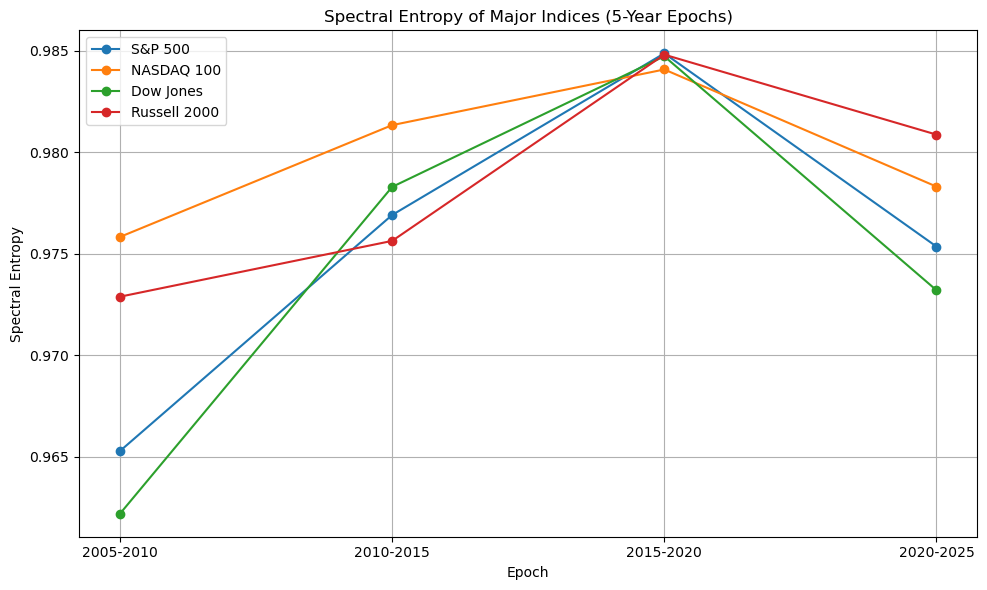

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import entropy

# -----------------------------
# Define entropy calculation
# -----------------------------
def spectral_entropy(series, fs=1.0):
    f, Pxx = welch(series, fs=fs, nperseg=min(256, len(series)))
    Pxx = Pxx / np.sum(Pxx)  # normalize to make it a probability distribution
    # return entropy(Pxx)
    return entropy(Pxx) / np.log(len(Pxx))

# -----------------------------
# Download historical data
# -----------------------------
tickers = {
    'SPY': 'S&P 500',
    'QQQ': 'NASDAQ 100',
    'DIA': 'Dow Jones',
    'IWM': 'Russell 2000'
}

start_date = '2005-01-01'
end_date = '2025-01-01'

data = yf.download(list(tickers.keys()), start=start_date, end=end_date)['Close']
log_returns = np.log(data / data.shift(1)).dropna()

# -----------------------------
# Define epochs (5-year windows)
# -----------------------------
epoch_years = [(2005, 2010), (2010, 2015), (2015, 2020), (2020, 2025)]
results = {name: [] for name in tickers.values()}

for start, end in epoch_years:
    for symbol, name in tickers.items():
        mask = (log_returns.index >= f'{start}-01-01') & (log_returns.index < f'{end}-01-01')
        segment = log_returns.loc[mask, symbol].dropna()
        se = spectral_entropy(segment)
        results[name].append(se)

# -----------------------------
# Plotting the results
# -----------------------------
labels = [f"{s}-{e}" for s, e in epoch_years]
fig, ax = plt.subplots(figsize=(10, 6))

for name, entropies in results.items():
    ax.plot(labels, entropies, marker='o', label=name)

ax.set_title("Spectral Entropy of Major Indices (5-Year Epochs)")
ax.set_ylabel("Spectral Entropy")
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

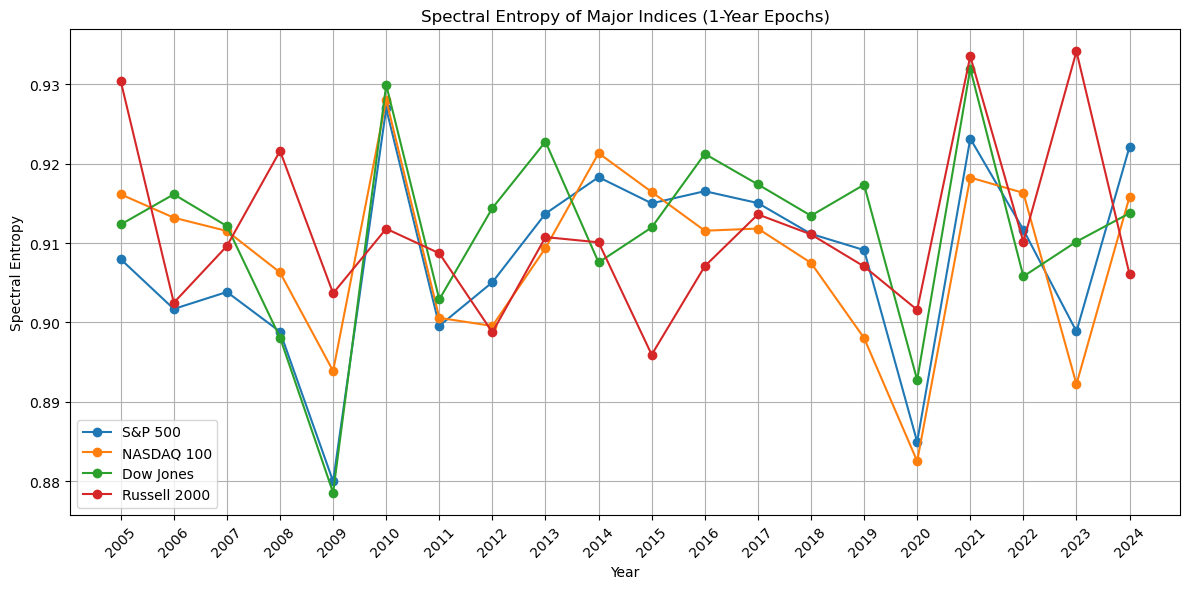

In [35]:
# Set up 1-year rolling windows
epoch_years = [(year, year + 1) for year in range(2000, 2025)]
results = {name: [] for name in tickers.values()}

# Compute spectral entropy for each window
for start, end in epoch_years:
    for symbol, name in tickers.items():
        mask = (log_returns.index >= f'{start}-01-01') & (log_returns.index < f'{end}-01-01')
        segment = log_returns.loc[mask, symbol].dropna()
        if len(segment) > 10:
            se = spectral_entropy(segment)
        else:
            se = np.nan
        results[name].append(se)

# Plotting
labels = [f"{s}" for s, _ in epoch_years]
fig, ax = plt.subplots(figsize=(12, 6))

for name, entropies in results.items():
    ax.plot(labels, entropies, marker='o', label=name)

ax.set_title("Spectral Entropy of Major Indices (1-Year Epochs)")
ax.set_ylabel("Spectral Entropy")
ax.set_xlabel("Year")
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


1 [2000] 2001
2 [2001] 2002
3 [2002] 2003
4 [2003] 2004
5 [2004] 2005
6 [2005] 2006
7 [2006] 2007
8 [2007] 2008
9 [2008] 2009
10 [2009] 2010
11 [2010] 2011
12 [2011] 2012
13 [2012] 2013
14 [2013] 2014
15 [2014] 2015
16 [2015] 2016
17 [2016] 2017
18 [2017] 2018
19 [2018] 2019
20 [2019] 2020
21 [2020] 2021
22 [2021] 2022
23 [2022] 2023


[*********************100%***********************]  1 of 1 completed

24 [2023] 2024
1 [2000] 2001
2 [2001] 2002


3 [2002] 2003
4 [2003] 2004
5 [2004] 2005
6 [2005] 2006
7 [2006] 2007
8 [2007] 2008
9 [2008] 2009
10 [2009] 2010
11 [2010] 2011
12 [2011] 2012
13 [2012] 2013
14 [2013] 2014
15 [2014] 2015
16 [2015] 2016
17 [2016] 2017
18 [2017] 2018
19 [2018] 2019
20 [2019] 2020
21 [2020] 2021
22 [2021] 2022
23 [2022] 2023
24 [2023] 2024


[*********************100%***********************]  1 of 1 completed


1 [2000] 2001
2 [2001] 2002
3 [2002] 2003
4 [2003] 2004
5 [2004] 2005
6 [2005] 2006
7 [2006] 2007
8 [2007] 2008
9 [2008] 2009
10 [2009] 2010
11 [2010] 2011
12 [2011] 2012
13 [2012] 2013
14 [2013] 2014
15 [2014] 2015
16 [2015] 2016
17 [2016] 2017
18 [2017] 2018
19 [2018] 2019
20 [2019] 2020
21 [2020] 2021
22 [2021] 2022


[*********************100%***********************]  1 of 1 completed

23 [2022] 2023
24 [2023] 2024
1 [2000] 2001


2 [2001] 2002
3 [2002] 2003
4 [2003] 2004
5 [2004] 2005
6 [2005] 2006
7 [2006] 2007
8 [2007] 2008
9 [2008] 2009
10 [2009] 2010
11 [2010] 2011
12 [2011] 2012
13 [2012] 2013
14 [2013] 2014
15 [2014] 2015
16 [2015] 2016
17 [2016] 2017
18 [2017] 2018
19 [2018] 2019
20 [2019] 2020
21 [2020] 2021
22 [2021] 2022
23 [2022] 2023
24 [2023] 2024


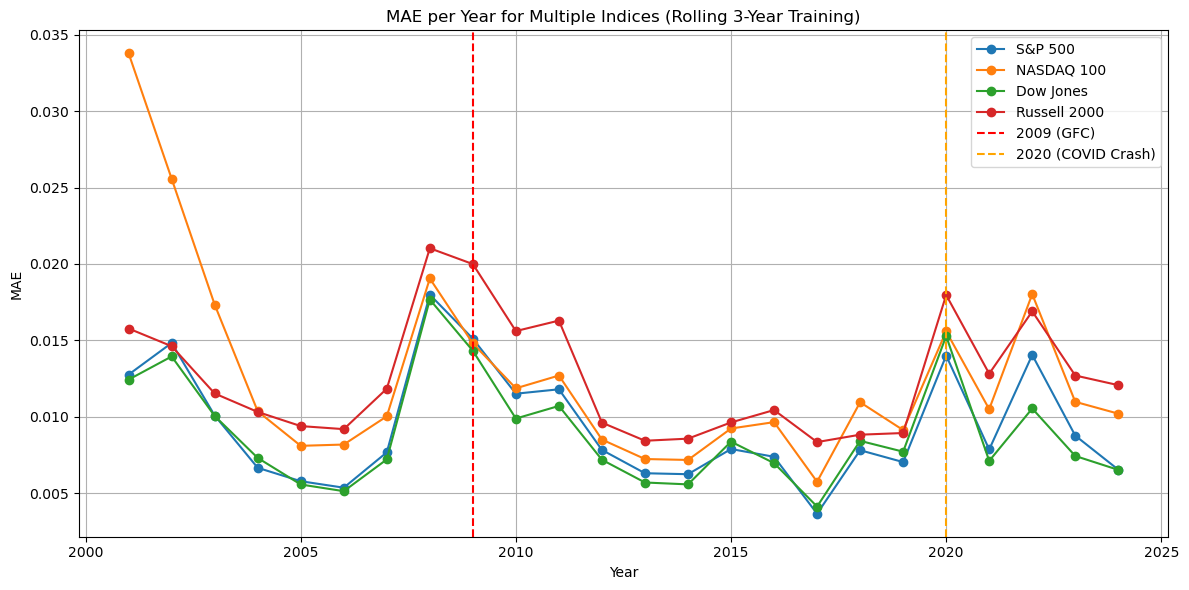

In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define ETF proxies for major indices
tickers = {
    'SPY': 'S&P 500',
    'QQQ': 'NASDAQ 100',
    'DIA': 'Dow Jones',
    'IWM': 'Russell 2000'
}

start_date = '2000-01-01'
end_date = '2024-12-31'
window_years = 1

# Store results
mape_dict = {}

for symbol, name in tickers.items():
    # Download data
    df = yf.download(symbol, start=start_date, end=end_date)
    if 'Adj Close' in df.columns:
        df = df[['Adj Close']].copy()
        df.rename(columns={'Adj Close': 'Price'}, inplace=True)
    elif 'Close' in df.columns:
        df = df[['Close']].copy()
        df.rename(columns={'Close': 'Price'}, inplace=True)
    else:
        print(f"Price column not found for {symbol}")
        continue

    # Features
    df['Return'] = np.log(df['Price'] / df['Price'].shift(1))
    df['Lag1'] = df['Return'].shift(1)
    df['Lag2'] = df['Return'].shift(2)
    df['MA5'] = df['Return'].rolling(5).mean().shift(1)
    df['MA10'] = df['Return'].rolling(10).mean().shift(1)
    df.dropna(inplace=True)
    df['Year'] = df.index.year

    years = sorted(df['Year'].unique())
    mape_results = []

    for i in range(window_years, len(years)):
        train_years = years[i-window_years:i]
        test_year = years[i]
        print(i, train_years, test_year)

        train = df[df['Year'].isin(train_years)]
        test = df[df['Year'] == test_year]

        X_train = train[['Lag1', 'Lag2', 'MA5', 'MA10']]
        y_train = train['Return']
        X_test = test[['Lag1', 'Lag2', 'MA5', 'MA10']]
        y_test = test['Return']

        if len(test) == 0 or len(train) == 0:
            continue

        model = XGBRegressor(n_estimators=300, max_depth=5, verbosity=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mape = mean_absolute_error(y_test, y_pred)
        mape_results.append((test_year, mape))

    mape_dict[name] = mape_results

# Plotting
plt.figure(figsize=(12, 6))
for name, mape_data in mape_dict.items():
    years, mapes = zip(*mape_data)
    plt.plot(years, mapes, marker='o', label=name)

plt.title("MAE per Year for Multiple Indices (Rolling 3-Year Training)")
plt.xlabel("Year")
plt.ylabel("MAE")
plt.axvline(2009, color='red', linestyle='--', label='2009 (GFC)')
plt.axvline(2020, color='orange', linestyle='--', label='2020 (COVID Crash)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


Processing S&P 500...



/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed


Processing NASDAQ 100...



/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed


Processing Dow Jones...



/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[*********************100%***********************]  1 of 1 completed


Processing Russell 2000...



/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Users/debanjansarkar/anaconda3/envs/erdos_data_science/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


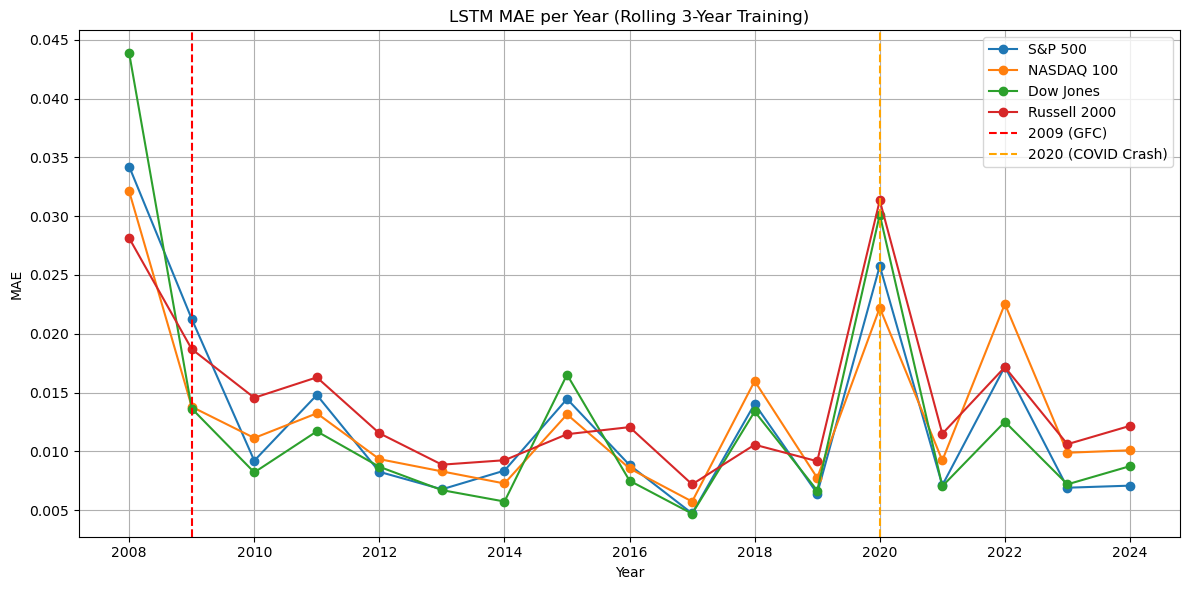

In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define tickers and names
tickers = {
    'SPY': 'S&P 500',
    'QQQ': 'NASDAQ 100',
    'DIA': 'Dow Jones',
    'IWM': 'Russell 2000'
}

start_date = '2005-01-01'
end_date = '2024-12-31'
window = 20
results = {}

# Loop over each index
for symbol, label in tickers.items():
    print(f"\nProcessing {label}...")
    df = yf.download(symbol, start=start_date, end=end_date)

    # Ensure we have a usable price column
    if 'Adj Close' in df.columns:
        df = df[['Adj Close']].copy()
        df.rename(columns={'Adj Close': 'Price'}, inplace=True)
    elif 'Close' in df.columns:
        df = df[['Close']].copy()
        df.rename(columns={'Close': 'Price'}, inplace=True)
    else:
        print(f"Skipping {symbol} — no price data.")
        continue

    # Feature engineering
    df['Return'] = np.log(df['Price'] / df['Price'].shift(1))
    df['Lag1'] = df['Return'].shift(1)
    df['Lag2'] = df['Return'].shift(2)
    df['MA5'] = df['Return'].rolling(5).mean().shift(1)
    df['MA10'] = df['Return'].rolling(10).mean().shift(1)
    df.dropna(inplace=True)
    df['Year'] = df.index.year

    features = ['Lag1', 'Lag2', 'MA5', 'MA10']
    years = sorted(df['Year'].unique())
    mae_by_year = []

    for i in range(3, len(years)):
        train_years = years[i-3:i]
        test_year = years[i]

        train_df = df[df['Year'].isin(train_years)]
        test_df = df[df['Year'] == test_year]

        if len(test_df) < window:
            continue

        # Scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_df[features])
        X_test = scaler.transform(test_df[features])
        y_train = train_df['Return'].values
        y_test = test_df['Return'].values

        # Sequence generation
        def make_sequences(X, y, window):
            X_seq, y_seq = [], []
            for j in range(window, len(X)):
                X_seq.append(X[j-window:j])
                y_seq.append(y[j])
            return np.array(X_seq), np.array(y_seq)

        X_train_seq, y_train_seq = make_sequences(X_train, y_train, window)
        X_test_seq, y_test_seq = make_sequences(X_test, y_test, window)

        if len(X_train_seq) == 0 or len(X_test_seq) == 0:
            continue

        # LSTM model
        model = Sequential([
            LSTM(32, input_shape=(window, len(features))),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        # Evaluation
        y_pred = model.predict(X_test_seq).flatten()
        mae = mean_absolute_error(y_test_seq, y_pred)
        mae_by_year.append((test_year, mae))

    results[label] = mae_by_year

# --- Plot results ---
plt.figure(figsize=(12, 6))
for label, mae_data in results.items():
    years, maes = zip(*mae_data)
    plt.plot(years, maes, marker='o', label=label)

plt.title("LSTM MAE per Year (Rolling 3-Year Training)")
plt.xlabel("Year")
plt.ylabel("MAE")
plt.axvline(2009, color='red', linestyle='--', label='2009 (GFC)')
plt.axvline(2020, color='orange', linestyle='--', label='2020 (COVID Crash)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()